In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('../Data/Raw/Sample - Superstore.csv', encoding="latin-1")

In [10]:
# Convert order date to numerical features
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Order_Year'] = df['Order Date'].dt.year
df['Order_Month'] = df['Order Date'].dt.month
df['Order_DayOfWeek'] = df['Order Date'].dt.dayofweek

# Select relevant features and drop nulls
features = ['Order_Year', 'Order_Month', 'Order_DayOfWeek', 'Ship Mode', 'Segment', 'Category']
target = 'Sales'

df_model = df[features + [target]].dropna()


In [11]:
X = df_model[features]
y = df_model[target]

# Define which columns are categorical
categorical_features = ['Ship Mode', 'Segment', 'Category']
numerical_features = ['Order_Year', 'Order_Month', 'Order_DayOfWeek']

# One-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'  # Leave numeric features as they are
)

In [12]:
# Build pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)


In [13]:
print("🔍 Regression Results:")
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

🔍 Regression Results:
R² Score: 0.04149657746290902
RMSE: 752.4540977622844


🔍 Regression Results (Holdout Test Set):
R² Score: 0.8451495682413221
RMSE: 133.04396933232385

📊 Cross-Validated R² Scores: [0.9384386  0.93345845 0.92723905 0.94114157 0.93231374]
CV R² Mean: 0.9345182834546216


/var/folders/f5/w_mc5b3155d4s32d7lrj3nm80000gn/T/ipykernel_4824/1195826484.py:84: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/divitanarang/miniconda/envs/zoomcamp/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


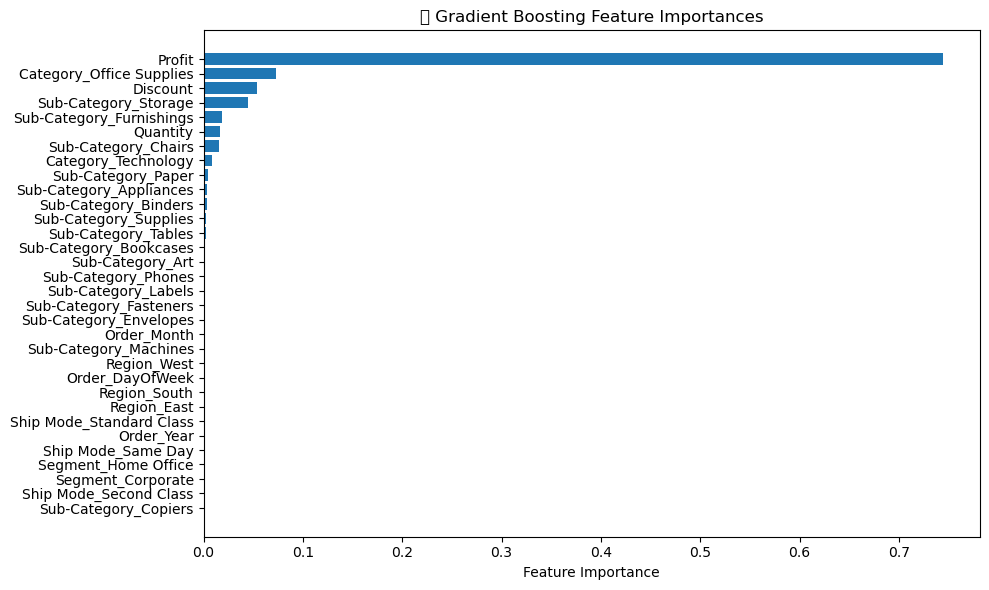

In [ ]:
#Model with feature selection and using GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
features = [
    'Order_Year', 'Order_Month', 'Order_DayOfWeek',
    'Ship Mode', 'Segment', 'Category', 'Region', 'Sub-Category',
    'Discount', 'Quantity', 'Profit'
]
target = 'Sales'

# Drop nulls
df_model = df[features + [target]].dropna()

# Remove outliers
upper_limit = df_model['Sales'].quantile(0.99)
df_model = df_model[df_model['Sales'] <= upper_limit]

# Log-transform target
df_model['Sales_log'] = np.log1p(df_model['Sales'])

X = df_model[features]
y = df_model['Sales_log']

# Categorical and numerical features
categorical_features = ['Ship Mode', 'Segment', 'Category', 'Region', 'Sub-Category']
numerical_features = ['Order_Year', 'Order_Month', 'Order_DayOfWeek', 'Discount', 'Quantity', 'Profit']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Regressor
regressor = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

print("🔍 Regression Results (Holdout Test Set):")
print("R² Score:", r2_score(y_test_actual, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_actual, y_pred)))

# 🔁 Cross-validation (R² Score)
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
print("\n📊 Cross-Validated R² Scores:", cv_scores)
print("CV R² Mean:", np.mean(cv_scores))

# 🔥 Feature importance
# Fit the pipeline again to access trained model
pipeline.fit(X, y)

# Extract feature names after preprocessing
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(categorical_features)
all_features = list(ohe_features) + numerical_features

# Get importances
importances = pipeline.named_steps['regressor'].feature_importances_

# Plot
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(importances)[::-1]
plt.barh(np.array(all_features)[sorted_idx], importances[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('🌟 Gradient Boosting Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 32 candidates, totalling 160 fits


Best hyperparameters found:  {'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 150, 'regressor__subsample': 0.8}
🔍 Regression Results (Holdout Test Set):
R² Score: 0.8473578341663808
RMSE: 132.09191699491265

📊 Cross-Validated R² Scores after Hyperparameter Tuning: [0.93696582 0.93191175 0.92508428 0.93842146 0.93244028]
CV R² Mean after Tuning: 0.9329647186577155


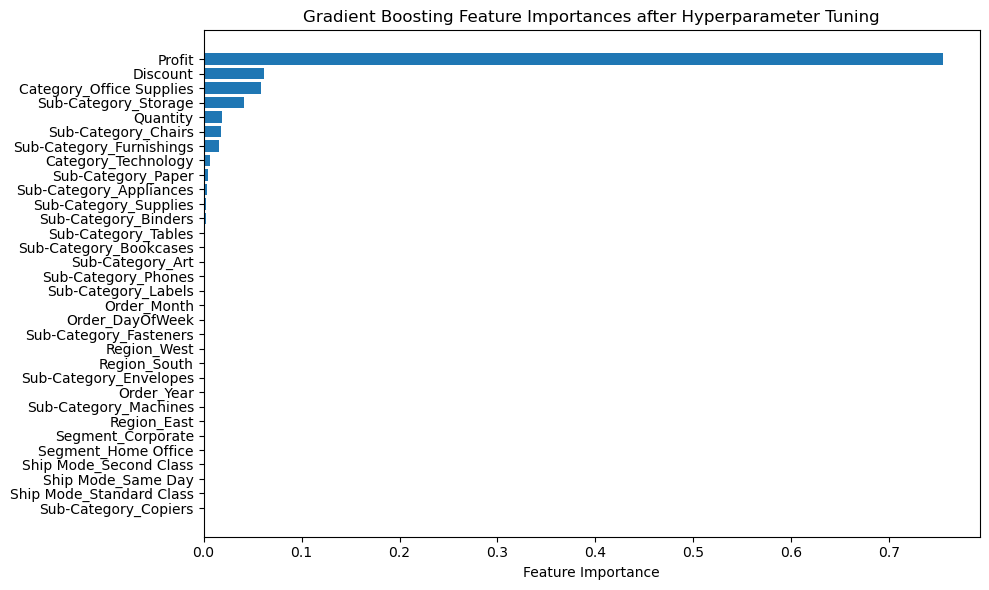

In [19]:
# Hyperparameter grid for GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 150],  
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 4],  
    'regressor__min_samples_split': [2, 5],  
    'regressor__subsample': [0.8, 1.0]  
}


# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
grid_search.fit(X_train, y_train)

# Best hyperparameters found by GridSearchCV
print("Best hyperparameters found: ", grid_search.best_params_)

# Predict using the best model
y_pred_log = grid_search.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Reverse the log-transformation
y_test_actual = np.expm1(y_test)

# Evaluate the model
print("🔍 Regression Results (Holdout Test Set):")
print("R² Score:", r2_score(y_test_actual, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_actual, y_pred)))

# Cross-validation (R² Scores after tuning)
cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5, scoring='r2')
print("\n📊 Cross-Validated R² Scores after Hyperparameter Tuning:", cv_scores)
print("CV R² Mean after Tuning:", np.mean(cv_scores))

# Feature importance for the best model
best_model = grid_search.best_estimator_
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(categorical_features)
all_features = list(ohe_features) + numerical_features

# Get importances
importances = best_model.named_steps['regressor'].feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(importances)[::-1]
plt.barh(np.array(all_features)[sorted_idx], importances[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting Feature Importances after Hyperparameter Tuning')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
